<a href="https://colab.research.google.com/github/AbiaAlvesReis/Projeto-IA-2022-01/blob/main/AMMS_Mega_IA_naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Lottery Predictions with Naive Bayes

In [ ]:
import matplotlib.pyplot as plt

Definições<br>

`ATTRIBUTES` é o tamanho do vetor de características, os valores sendo os últimos números `ATTRIBUTES+1` para uma escolha com o elemento `ATTRIBUTES+1`th sendo a classe.

In [ ]:
ATTRIBUTES = 1
PICKS = 6

MIN = 1
MAX = 60

LAPLACE_M = 6

A classe 'Pick' codifica a coluna, os vetores de treinamento, a entrada e as classes. Em 'f_vec' a entrada atual para a qual uma previsão é feita é salva.

In [ ]:
class Pick:
    def __init__(self, pos, data, f_vec, classes):
        self.pos = pos
        self.data = data
        self.f_vec = f_vec
        self.classes = classes

<br>

## Data

In [ ]:
mega_df = pd.read_excel('/content/drive/MyDrive/2022/IA - projeto/megas.xlsx')

str_total = ''
for index, row in mega_df.iterrows():
  f1 = int(row['ball_01'])
  f2 = int(row['ball_02'])
  f3 = int(row['ball_03'])
  f4 = int(row['ball_04'])
  f5 = int(row['ball_05'])
  f6 = int(row['ball_06'])
  str_total = str_total +  (f'{f1}-{f2}-{f3}-{f4}-{f5}-{f6}\n')

f = open("data.txt","w+")
f.write(str_total)

def read_data():
    with open("data.txt", 'r') as file:
        return np.array([v.split('-') for v in file.read().splitlines()])

        

Each line is a set of 6 rolled numbers.

In [ ]:
data = read_data()
print(pd.DataFrame(data))

       0   1   2   3   4   5
0     59  36  41  54  14  11
1     54  49  34  38  40  20
2     32   1  57  44  35  45
3      1  37  36  21   8  27
4     31  56   6   4  50   9
...   ..  ..  ..  ..  ..  ..
2479   1  19  46   6  16   2
2480   6  59  42  27   1   5
2481  36  30  10  11  29  47
2482   9  39  37  49  43  41
2483  41   5   4  52  30  33

[2484 rows x 6 columns]


The numbers in each column are treated seperately from the other columns, so 6 arrays consisting of the numbers in the respective columns are created.

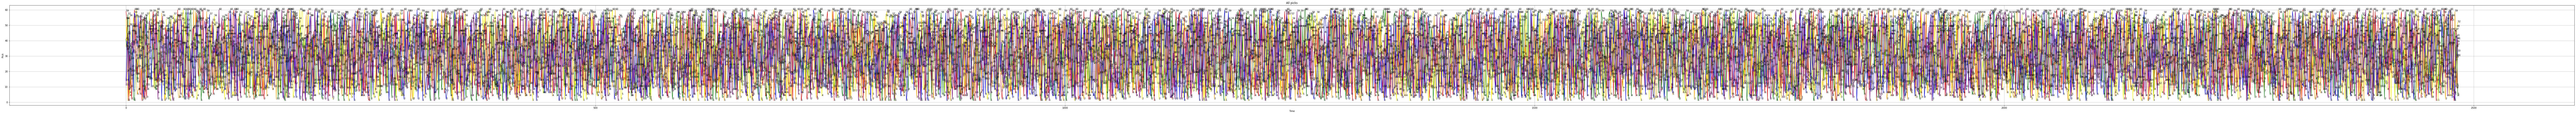

In [ ]:
numbers = np.array(np.stack(read_data(), axis=1), dtype='i')

x = np.arange(numbers.shape[1])

plt.figure(figsize=(200,8))
plt.title("All picks")
plt.xlabel("Time")
plt.ylabel("Pick")
plt.grid(True)
colors = ["red", "orange", "green", "yellow", "blue", "purple"]
for i in range(numbers.shape[0]):
    plt.plot(x, numbers[i], color=colors[i])
    for j in range(numbers.shape[1]):
        plt.annotate(numbers[i][j], (j, numbers[i][j]))

plt.show()

<br>

## Processing

The `Pick` objects are initialized, one object for every column.

In [ ]:
def process_data(pos, numbers):
    data_vecs = np.empty(shape=(len(numbers)-ATTRIBUTES, ATTRIBUTES+1), dtype='i')
    for k, j in enumerate(range(ATTRIBUTES, len(numbers))):
        data_vecs[k] = np.array(numbers[j-ATTRIBUTES:j+1])
        
    return Pick(pos, data_vecs, np.array(numbers[-ATTRIBUTES:], dtype='i'), np.stack(data_vecs[:,-1]))

<br>

## Learning

The dependencies are learned by calculating the probabilities. As a result of data sparsity, `LAPLACE_M` does not really have a meaningful influence.

The key in the probabilities dictionary is a tuple of (Attribute, Value, Class), which saves the probability of the occurence of a number in a attribute, given the class.

In [ ]:
def learn(pick):
    probabilities = {}
    for i in range(ATTRIBUTES):
        for c in np.unique(pick.classes):
            for j in range(MIN, MAX+1):
                attr_occs = np.count_nonzero(np.logical_and(pick.data[:, i] == j, pick.data[:, -1] == c))
                if attr_occs > 0:
                    class_ocs = np.count_nonzero(pick.classes == c)
                    probabilities[(i, j, c)] = attr_occs/class_ocs
                else:
                    probabilities[(i, j, c)] = LAPLACE_M * (1/(MAX-(PICKS-1)))
    return probabilities

<br>

## Classifying

Given the latest numbers in the respective columns, the class with the biggest probability is picked as the prediction.

In [ ]:
def classify(pick, probs):
    argmax = 0
    currmax = 0
    c_len = len(pick.classes)
    for c in np.unique(pick.classes):
        prob = np.count_nonzero(pick.classes == c)/c_len
        for i in range(ATTRIBUTES):
            prob *= probs[(i, pick.f_vec[i], c)]
        if prob > currmax:
            argmax, currmax = c, prob
    return argmax

<br>

## Result

In [ ]:
result = np.empty(shape=(PICKS), dtype='i')
for i in range(PICKS):
    pick = process_data(i, numbers[i])
    probabilities = learn(pick)
    result[i] = classify(pick, probabilities)

print(result)

[49 10 27 37 35 16]
